## Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
---

# 1. Imports 

In [1]:
#Some Imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import math
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import warnings

import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label


%matplotlib inline

/Users/benjamin.chang/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/benjamin.chang/anaconda/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


# 2. Classifier Feature Extraction

### Some Helper functions:

In [2]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
#def bin_spatial(img, color_space='RGB', size=(32, 32)):
#def bin_spatial(img, color_space='RGB', size=(32, 32)):
def bin_spatial(img, size=(32, 32)):      
    feature_image = np.copy(img)       
    # Use cv2.resize().ravel() to create the feature vector
    small_img = cv2.resize(feature_image, size)
    features = small_img.ravel() 
    # Return the feature vector
    return features

In [3]:
def get_feature_image(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else: feature_image = np.copy(img)  
    return feature_image

In [4]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



In [5]:


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features



In [6]:

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', orient=9, 
                        spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)*255
        # apply color conversion if other than 'RGB'
        feature_image = get_feature_image(image, color_space = color_space)     

        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

# 3. Definition of Classifier Variables

In [7]:

colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 16
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 64

spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#y_start_stop = [400, None] # Min and max in y to search in slide_window()

heatmap_threshold = 3


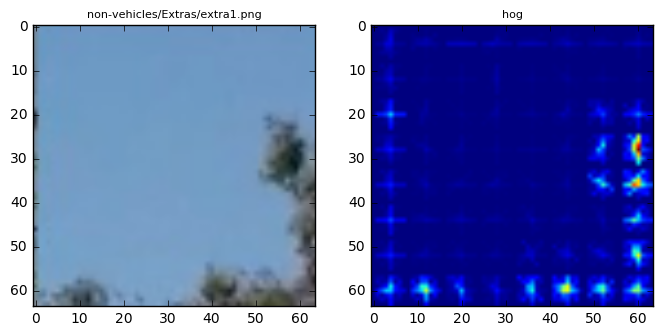

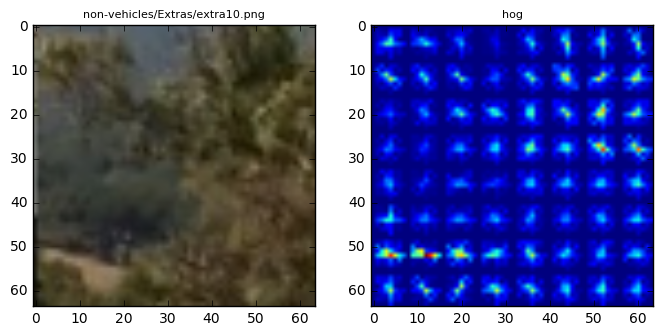

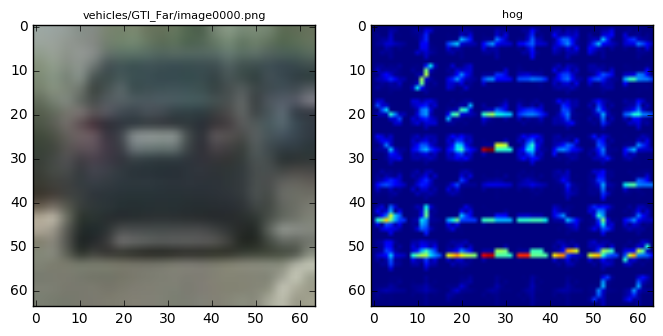

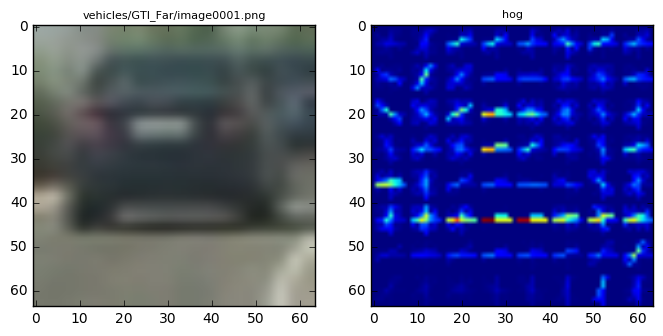

In [8]:
imgs_to_display = 2

images = glob.glob('non-vehicles/*/*.png')[:imgs_to_display]
images.extend( glob.glob('vehicles/*/*.png')[:imgs_to_display])
for ifile in images:
    img = mpimg.imread(ifile)
    feature_image = get_feature_image(img, color_space = colorspace)
    
    
    features, hog_image = get_hog_features(feature_image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
        
       
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.imshow(img)
    ax1.set_title(ifile, fontsize=8)
    
    ax2.imshow( hog_image )
    ax2.set_title("hog", fontsize=8)



# 4. Training the Classifier

In [9]:

# Read in car and non-car images
cars = []
notcars = []
noncar_images = glob.glob('non-vehicles/*/*.png')
for image in noncar_images:
    notcars.append(image)

car_images = glob.glob('vehicles/*/*.png')
for image in car_images:
    cars.append(image)

# TODO play with these values to see how your classifier
# performs under different binning scenarios

print("start loading features")
t=time.time()
car_features = extract_features(cars, color_space=colorspace, orient=orient, 
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, color_space=colorspace, orient=orient, 
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to features...')


start loading features
(79.34, 'Seconds to features...')


In [10]:

# Create an array stack of feature vectors
print("car_feature: lengh = ", len(car_features),"feature size =",car_features[0].shape)
print("notcar_features: lengh = ", len(notcar_features),"feature size =",notcar_features[0].shape)
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


('car_feature: lengh = ', 8792, 'feature size =', (12672,))
('notcar_features: lengh = ', 8968, 'feature size =', (12672,))


In [11]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 20
print('My SVC predicts: ')
print(svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ')
print(y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

('Using:', 16, 'orientations', 8, 'pixels per cell and', 2, 'cells per block')
('Feature vector length:', 12672)
(15.12, 'Seconds to train SVC...')
('Test Accuracy of SVC = ', 0.9823)
My SVC predicts: 
[ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.  0.  1.  0.  1.  1.  0.  0.
  1.  0.]
('For these', 20, 'labels: ')
[ 1.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.  0.  1.  0.  1.  1.  0.  0.
  1.  0.]
(0.00323, 'Seconds to predict', 20, 'labels with SVC')


# 5. Dividing Frame into Windows

### Some Helper functions:

In [12]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [13]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    if x_start_stop[0] is None:
        x_start_stop[0] = 0
        
    if y_start_stop[1] is None:
        y_start_stop[1] = img.shape[0]
    if x_start_stop[1] is None:
        x_start_stop[1] = img.shape[1]
        
    # Compute the span of the region to be searched    
    y_span = y_start_stop[1] - y_start_stop[0]
    x_span = x_start_stop[1] - x_start_stop[0]
    # Compute the number of pixels per step in x/y
    y_delta = np.int(xy_window[1]*(1-xy_overlap[1]))
    x_delta = np.int(xy_window[0]*(1-xy_overlap[0]))
    # Compute the number of windows in x/y
    y_steps = 1 + np.int((y_span - xy_window[1])/y_delta)
    x_steps = 1 + np.int((x_span - xy_window[0])/x_delta)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for i_y in range(y_steps):
        for i_x in range(x_steps):
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
            # Calculate each window position
            y_start = y_start_stop[0] + (i_y * y_delta)
            y_end = y_start + xy_window[0]
            x_start = x_start_stop[0] + (i_x * x_delta)
            x_end = x_start + xy_window[1]
            # Append window position to list
            window_list.append(((x_start, y_start), (x_end, y_end)))
    # Return the list of windows
    return window_list

### Test Bed for Widow Drawing:

['test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


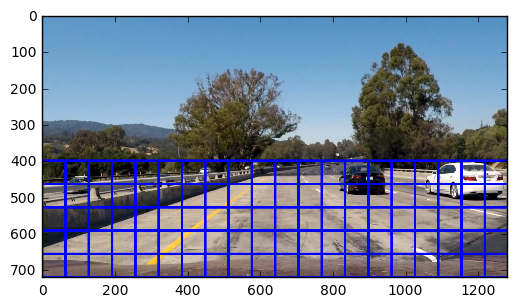

In [14]:

test_images = glob.glob('test_images/*.jpg')
print test_images
for image_path in test_images:
    image = mpimg.imread(image_path)
    windows = []
    #windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 500], 
    #                xy_window=(48, 48), xy_overlap=(0.5, 0.5))
    #windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 600], 
    #                xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    #windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 700], 
    #                xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[400, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
    window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
    plt.imshow(window_img)
    plt.show()
    break


# 6. Frame Processing: Invoking Classifier

### Some Helper functions:

In [15]:
#function to extract feature for an image window    
def single_img_features(feature_image, spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
         
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))  
            hog_features = np.ravel(hog_features)            
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [16]:
def search_windows(img, windows, clf, X_scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    feature_image = get_feature_image(img, color_space = color_space)
    
    #hog_feature_array = hog(feature_image, orientations=orient, 
    #                    pixels_per_cell=(pix_per_cell, pix_per_cell), 
    #                    cells_per_block=(cell_per_block, cell_per_block), 
    #                    visualise=False, feature_vector=False)
    
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(feature_image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img,
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = X_scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [17]:
def increment_heatmap(heatmap,window):
    for y in range(window[0][1],window[1][1]):
        for x in range(window[0][0],window[1][0]):
            heatmap[y][x] += 1
    return heatmap

def make_heatmap(img, windows):
    heatmap = np.zeros_like(img[:,:,0])
    for window in windows:
        heatmap = increment_heatmap(heatmap,window)
    heatmap[0][0] = 20
    return heatmap

In [18]:

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def heatmap_to_windows(img, heatmap):
    #heatmap = apply_threshold(heatmap, heatmap_threshold)
    labels = label(heatmap)
    return draw_labeled_bboxes(img, labels)


### Test Bed for Detecting Vehicles in a Single Frame:

['test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


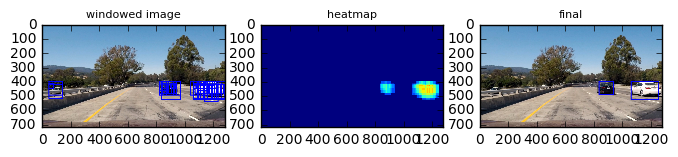

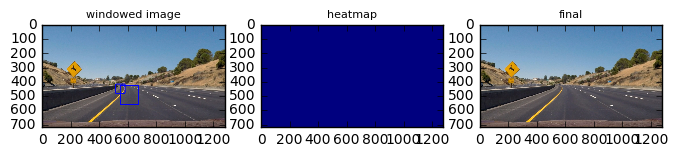

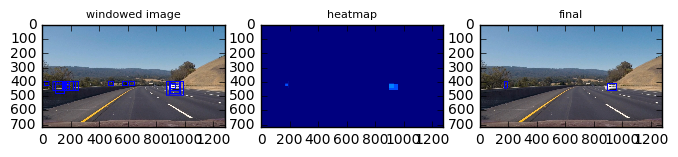

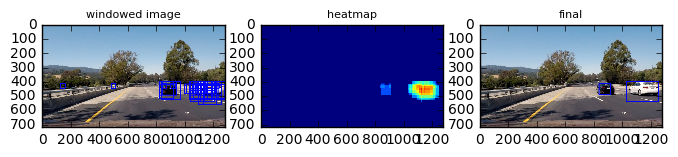

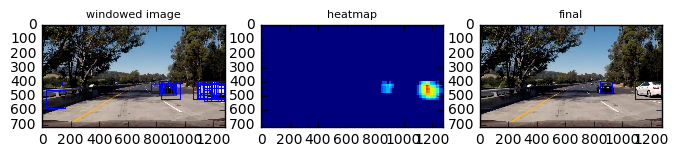

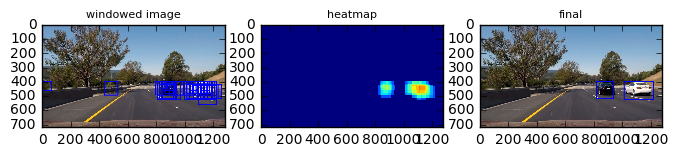

In [19]:

test_images = glob.glob('test_images/*.jpg')
print test_images
for image_path in test_images:
    image = mpimg.imread(image_path)
    draw_image = np.copy(image)
    
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 450], 
                    xy_window=(32, 32), xy_overlap=(0.5, 0.5))
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                    xy_window=(64, 64), xy_overlap=(0.70, 0.70))
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 550], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[400, None], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    heatmap = make_heatmap(window_img,hot_windows)
    heatmap = apply_threshold(heatmap, heatmap_threshold)
                       
    cleaned_window_img = heatmap_to_windows(draw_image, heatmap)
    
    
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(8,4))
    ax1.imshow(window_img)
    ax1.set_title("windowed image", fontsize=8)
    
    ax2.imshow( heatmap )
    ax2.set_title("heatmap", fontsize=8)
    
    ax3.imshow( cleaned_window_img )
    ax3.set_title("final", fontsize=8)
    
    #plt.show()


# Processing Videos:

### Class to Process Each Frame in a Video:

In [20]:
class detect_cars():  
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.prev_heatmap = None
        
    def annotate_image(self,image):
        draw_image = np.copy(image)

        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 450], 
                        xy_window=(32, 32), xy_overlap=(0.5, 0.5))
        windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                        xy_window=(64, 64), xy_overlap=(0.70, 0.70))
        windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 550], 
                        xy_window=(96, 96), xy_overlap=(0.75, 0.75))
        windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[400, None], 
                        xy_window=(128, 128), xy_overlap=(0.75, 0.75))
        
        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)                       
        
        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
        heatmap = make_heatmap(window_img,hot_windows)
        heatmap = apply_threshold(heatmap, heatmap_threshold)
        tmp_heatmap = apply_threshold(heatmap, heatmap_threshold+1)
        if self.prev_heatmap is not None:
            heatmap = np.add(heatmap,self.prev_heatmap)
        
        cleaned_window_img = heatmap_to_windows(draw_image, heatmap)
        self.prev_heatmap = tmp_heatmap
        return cleaned_window_img


In [21]:
test_output = 'test_result.mp4'
clip1 = VideoFileClip('test_video.mp4')
dc = detect_cars()
clip = clip1.fl_image(dc.annotate_image)
%time clip.write_videofile(test_output, audio=False)


MoviePy: building video file test_result.mp4
----------------------------------------

Writing video into test_result.mp4
Done writing video in test_result.mp4 !
Your video is ready !
CPU times: user 8min 25s, sys: 6.01 s, total: 8min 31s
Wall time: 2min 17s


In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(test_output))

In [ ]:
test_output = 'project_result.mp4'
clip1 = VideoFileClip('project_video.mp4')
dc = detect_cars()
clip = clip1.fl_image(dc.annotate_image)
#clip = clip1.fl_image(annotate_image)
%time clip.write_videofile(test_output, audio=False)


MoviePy: building video file project_result.mp4
----------------------------------------

Writing video into project_result.mp4
|###-------| 404/1210  33% [elapsed: 23:39 left: 47:12,  0.28 iters/sec]

In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(test_output))